## Install and Import Required Libraries

In [13]:
import os
import json
import re
import math
import sys
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Tuple, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def find_data_path():
    env_path = os.environ.get("CODE_COMPLEXITY_PATH") or os.environ.get("CODE_COMPLEXITY_DIR")
    if env_path:
        p = Path(env_path).expanduser()
        if p.is_file():
            return p.resolve()
        if p.is_dir():
            cand = p / "code_complexity.jsonl"
            if cand.exists():
                return cand.resolve()

    direct_candidates = [
        Path("/kaggle/input/codeforces-dataset/code_complexity.jsonl"),
        Path("/kaggle/input/Codeforces_DataSet/code_complexity.jsonl"),
        Path("/kaggle/input/machine-learning-based-runtime-complexity-classification/Codeforces_DataSet/code_complexity.jsonl"),
        Path("/kaggle/input/machine-learning-based-runtime-complexity-classification/code_complexity.jsonl"),
        Path("/kaggle/input/time-complexity-dataset-python-codes/data.jsonl"),
        Path("Codeforces_DataSet/code_complexity.jsonl"),
        Path("../Codeforces_DataSet/code_complexity.jsonl"),
        Path("../../Codeforces_DataSet/code_complexity.jsonl"),
        Path.cwd() / "Codeforces_DataSet" / "code_complexity.jsonl",
    ]
    for cand in direct_candidates:
        if cand.exists():
            return cand.resolve()

    search_roots = [
        Path("/kaggle/input/machine-learning-based-runtime-complexity-classification"),
        Path("/kaggle/input"),
        Path.cwd(),
        Path.cwd().parent,
    ]
    for root in search_roots:
        if root.exists():
            for cand in root.rglob("code_complexity.jsonl"):
                return cand.resolve()

    raise FileNotFoundError(
        "Could not locate code_complexity.jsonl. Set CODE_COMPLEXITY_PATH env var or upload the file to /kaggle/input/machine-learning-based-runtime-complexity-classification/Codeforces_DataSet/."
    )

DATA_PATH = find_data_path()

PREPROC_DIR = Path.cwd() / "preprocessing module"
if not PREPROC_DIR.exists():
    alt_pre = Path.cwd().parent / "preprocessing module"
    if alt_pre.exists():
        PREPROC_DIR = alt_pre
if PREPROC_DIR.exists():
    sys.path.append(str(PREPROC_DIR))

def normalize_indentation(code: str) -> str:
    tree = ast.parse(code)
    return ast.unparse(tree)

print(f"Using device: {device}")
print(f"Data path: {DATA_PATH}")
print(f"Preprocessing module path: {PREPROC_DIR}")

Using device: cuda
Data path: /kaggle/input/code_complexity.jsonl
Preprocessing module path: /kaggle/working/preprocessing module


## Load and Explore Data

In [15]:
def load_jsonl(filepath: Path) -> List[Dict]:
    """Load data from JSONL file"""
    filepath = filepath if isinstance(filepath, Path) else Path(filepath)
    data = []
    with filepath.open('r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

def safe_normalize(code: str) -> str:
    """Normalize indentation; fall back to raw code on errors"""
    try:
        return normalize_indentation(code)
    except Exception:
        return code

data = load_jsonl(DATA_PATH)
df = pd.DataFrame(data)
df['code_norm'] = df['code'].apply(safe_normalize)

label2id = {label: idx for idx, label in enumerate(sorted(df['complexity'].unique()))}
id2label = {idx: label for label, idx in label2id.items()}
df['label'] = df['complexity'].map(label2id)
NUM_CLASSES = len(label2id)

print(f"Total samples: {len(df)}")
print(f"Classes: {label2id}")
df.head()

Total samples: 4900
Classes: {'constant': 0, 'cubic': 1, 'linear': 2, 'logn': 3, 'nlogn': 4, 'np': 5, 'quadratic': 6}


,code,complexity,code_norm,label
0,"from math import sqrt\na, v = map(int, input()...",constant,"from math import sqrt\na, v = map(int, input()...",0
1,"from math import *\na, vm = map(int, input().s...",constant,"from math import *\na, vm = map(int, input().s...",0
2,"import os\nimport sys\nfrom io import BytesIO,...",constant,"import os\nimport sys\nfrom io import BytesIO,...",0
3,"from math import *\na, vm = map(int, input().s...",constant,"from math import *\na, vm = map(int, input().s...",0
4,"from math import *\na, v = list(map(int, input...",constant,"from math import *\na, v = list(map(int, input...",0


Class Distribution:
label
0    791
1    606
2    853
3    669
4    796
5    528
6    657
Name: count, dtype: int64


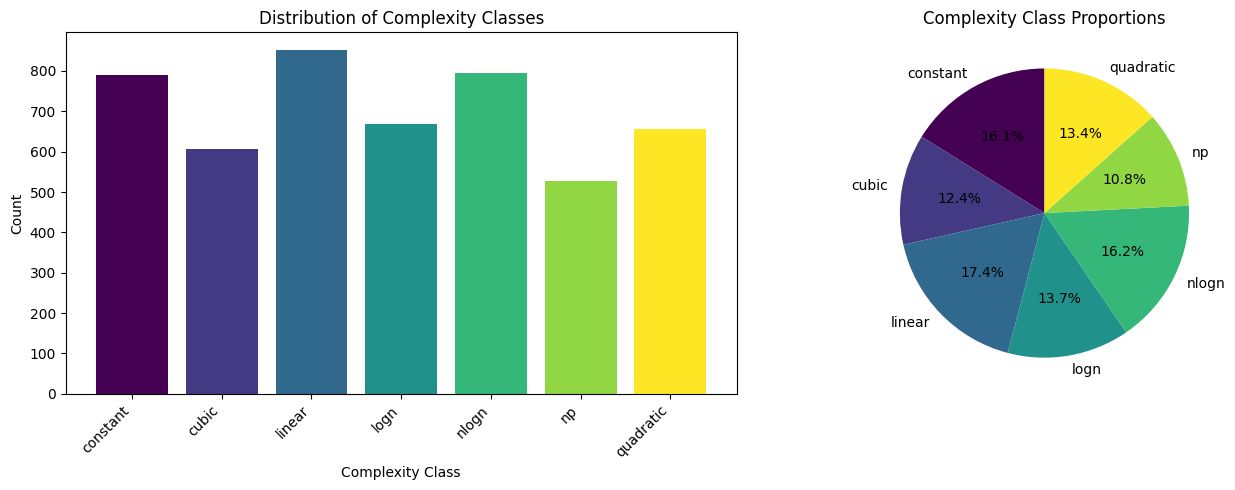


Code Length Statistics:
count     4900.000000
mean       848.965102
std       1679.242314
min          9.000000
25%        269.000000
50%        488.000000
75%        889.000000
max      64448.000000
Name: code_length, dtype: float64


In [16]:
complexity_labels = id2label

print("Class Distribution:")
print(df['label'].value_counts().sort_index())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts = df['label'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors)
axes[0].set_xlabel('Complexity Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Complexity Classes')
axes[0].set_xticks(range(NUM_CLASSES))
axes[0].set_xticklabels([complexity_labels[i] for i in range(NUM_CLASSES)], rotation=45, ha='right')

axes[1].pie(class_counts.values, labels=[complexity_labels[i] for i in class_counts.index], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Complexity Class Proportions')

plt.tight_layout()
plt.show()

df['code_length'] = df['code_norm'].apply(len)
print(f"\nCode Length Statistics:")
print(df['code_length'].describe())

## Code Tokenization


In [21]:
class PythonCodeTokenizer:
    """Custom tokenizer for Python code"""
    
    # Python keywords
    KEYWORDS = {
        'False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await',
        'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except',
        'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is',
        'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try',
        'while', 'with', 'yield'
    }
    
    # Built-in functions commonly used
    BUILTINS = {
        'abs', 'all', 'any', 'bin', 'bool', 'chr', 'dict', 'divmod', 'enumerate',
        'filter', 'float', 'hash', 'hex', 'input', 'int', 'iter', 'len', 'list',
        'map', 'max', 'min', 'next', 'oct', 'open', 'ord', 'pow', 'print', 'range',
        'reversed', 'round', 'set', 'slice', 'sorted', 'str', 'sum', 'super',
        'tuple', 'type', 'zip'
    }
    
    # Special tokens
    SPECIAL_TOKENS = ['<PAD>', '<UNK>', '<CLS>', '<SEP>', '<NUM>', '<STR>', '<VAR>', '<NEWLINE>', '<INDENT>', '<DEDENT>']
    
    def __init__(self, max_vocab_size: int = 4000):
        self.max_vocab_size = max_vocab_size
        self.token2idx = {}
        self.idx2token = {}
        self.vocab_size = 0
        
    def _tokenize_code(self, code: str) -> List[str]:
        """Tokenize a single code snippet"""
        tokens = []

        lines = code.split('\n')
        for line in lines:
            stripped = line.lstrip()
            indent_level = (len(line) - len(stripped)) // 4
            
            for _ in range(indent_level):
                tokens.append('<INDENT>')
            
            pattern = r'''
                ("[^"]*"|'[^']*')           # String literals
                |(\d+\.?\d*|\.\d+)           # Numbers
                |(\w+)                        # Identifiers and keywords
                |([+\-*/%@&|^~<>=!:;,.()\[\]{}])  # Operators and punctuation
                |(\s+)                        # Whitespace (captured but filtered)
            '''
            
            for match in re.finditer(pattern, stripped, re.VERBOSE):
                string_lit, number, identifier, operator, whitespace = match.groups()
                
                if string_lit:
                    tokens.append('<STR>')
                elif number:
                    tokens.append('<NUM>')
                elif identifier:
                    if identifier in self.KEYWORDS:
                        tokens.append(identifier)
                    elif identifier in self.BUILTINS:
                        tokens.append(identifier)
                    else:
                        tokens.append('<VAR>')
                elif operator:
                    tokens.append(operator)

            if stripped:
                tokens.append('<NEWLINE>')
        
        return tokens
    
    def build_vocab(self, codes: List[str]):
        """Build vocabulary from training data"""

        token_counter = Counter()
        for code in tqdm(codes, desc="Building vocabulary"):
            tokens = self._tokenize_code(code)
            token_counter.update(tokens)
        
        self.token2idx = {token: idx for idx, token in enumerate(self.SPECIAL_TOKENS)}
        
        most_common = token_counter.most_common(self.max_vocab_size - len(self.SPECIAL_TOKENS))
        for token, _ in most_common:
            if token not in self.token2idx:
                self.token2idx[token] = len(self.token2idx)
        
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        self.vocab_size = len(self.token2idx)
        print(f"Vocabulary size: {self.vocab_size}")
    
    def encode(self, code: str, max_length: int = 512) -> List[int]:
        """Encode code to token indices"""
        tokens = self._tokenize_code(code)
        
        tokens = ['<CLS>'] + tokens[:max_length - 2] + ['<SEP>']
        
        indices = []
        for token in tokens:
            if token in self.token2idx:
                indices.append(self.token2idx[token])
            else:
                indices.append(self.token2idx['<UNK>'])

        if len(indices) < max_length:
            indices.extend([self.token2idx['<PAD>']] * (max_length - len(indices)))
        
        return indices[:max_length]
    
    def decode(self, indices: List[int]) -> str:
        """Decode token indices back to tokens"""
        tokens = [self.idx2token.get(idx, '<UNK>') for idx in indices]
        return ' '.join(tokens)

tokenizer = PythonCodeTokenizer(max_vocab_size=3000)
tokenizer.build_vocab(df['code_norm'].tolist())

Building vocabulary:   0%|          | 0/4900 [00:00<?, ?it/s]

Vocabulary size: 101


In [22]:
sample_code = df['code_norm'].iloc[0]
print("Original Code:")
print(sample_code)
print("\nTokenized:")
tokens = tokenizer._tokenize_code(sample_code)
print(tokens)
print(f"\nNumber of tokens: {len(tokens)}")

Original Code:
from math import sqrt
a, v = map(int, input().split())
l, d, w = map(int, input().split())

def findt(u, v, a, dist):
    front = (v * v - u * u) / (2 * a)
    if front > dist:
        return (sqrt(u * u + 2 * a * dist) - u) / a
    return (v - u) / a + (dist - front) / v

def solve(a, v, l, d, w):
    if v <= w or 2 * a * d <= w * w:
        return findt(0, v, a, l)
    after = findt(w, v, a, l - d)
    peak = sqrt(a * d + w * w / 2)
    if peak > v:
        travel = (v * v - w * w / 2) / a
        before = (2 * v - w) / a + (d - travel) / v
    else:
        before = (2 * peak - w) / a
    return before + after
print(f'{solve(a, v, l, d, w):.8f}')

Tokenized:
['from', '<VAR>', 'import', '<VAR>', '<NEWLINE>', '<VAR>', ',', '<VAR>', '=', 'map', '(', 'int', ',', 'input', '(', ')', '.', '<VAR>', '(', ')', ')', '<NEWLINE>', '<VAR>', ',', '<VAR>', ',', '<VAR>', '=', 'map', '(', 'int', ',', 'input', '(', ')', '.', '<VAR>', '(', ')', ')', '<NEWLINE>', 'def', '<VAR>', '(', '<VA

## Processing Dataset for encoder

In [23]:
class CodeComplexityDataset(Dataset):
    """PyTorch Dataset for code complexity classification"""
    
    def __init__(self, codes: List[str], labels: List[int], tokenizer: PythonCodeTokenizer, max_length: int = 256):
        self.codes = codes
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.codes)
    
    def __getitem__(self, idx):
        code = self.codes[idx]
        label = self.labels[idx]
        
        input_ids = self.tokenizer.encode(code, max_length=self.max_length)
        
        attention_mask = [1 if token_id != self.tokenizer.token2idx['<PAD>'] else 0 
                         for token_id in input_ids]
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

codes = df['code_norm'].tolist()
labels = df['label'].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    codes, labels, test_size=0.2, stratify=labels, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

MAX_LENGTH = 320
BATCH_SIZE = 32

train_dataset = CodeComplexityDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = CodeComplexityDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = CodeComplexityDataset(X_test, y_test, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nNumber of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Training samples: 3920
Validation samples: 490
Test samples: 490

Number of batches - Train: 123, Val: 16, Test: 16


## Transformer Encoder Model Architecture

In [24]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for transformer"""
    
    def __init__(self, d_model: int, max_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) 
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):

        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    """Transformer Encoder for Code Complexity Classification"""
    
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 192,
        nhead: int = 8,
        num_layers: int = 2,
        dim_feedforward: int = 768,
        num_classes: int = NUM_CLASSES,
        max_len: int = 512,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) * math.sqrt(self.d_model) 
        
        x = self.pos_encoder(x)
        

        if attention_mask is not None:

            src_key_padding_mask = (attention_mask == 0)
        else:
            src_key_padding_mask = None
        
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        cls_output = x[:, 0, :]
        
        logits = self.classifier(cls_output)
        
        return logits


MODEL_CONFIG = {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 192,
    'nhead': 8,
    'num_layers': 2,
    'dim_feedforward': 768,
    'num_classes': NUM_CLASSES,
    'max_len': MAX_LENGTH,
    'dropout': 0.1
}


model = TransformerClassifier(**MODEL_CONFIG).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel Architecture:")
print(model)

Total parameters: 947,911
Trainable parameters: 947,911

Model Architecture:
TransformerClassifier(
  (embedding): Embedding(101, 192, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=768, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_

## Training Functions

In [25]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

## Train the Model

In [26]:
NUM_EPOCHS = 20
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.01

class_counts = np.bincount(y_train, minlength=NUM_CLASSES)
class_weights = torch.tensor(
    [1.0 / count if count > 0 else 0.0 for count in class_counts],
    dtype=torch.float32
).to(device)
class_weights = class_weights / class_weights.sum() * len(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * NUM_EPOCHS
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos'
)

print(f"Training for {NUM_EPOCHS} epochs")
print(f"Total training steps: {total_steps}")
print(f"Class weights: {class_weights.cpu().numpy()}")

Training for 20 epochs
Total training steps: 2460
Class weights: [0.8627461  1.1260171  0.8007599  1.0207818  0.85732853 1.2941191
 1.0382476 ]


In [27]:
best_val_f1 = 0
patience = 5
patience_counter = 0
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}


for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device
    )
    
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'model_config': MODEL_CONFIG
        }, 'best_model.pt')
        print("Saved best model!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break
    
    print()

print(f"\nBest Validation F1: {best_val_f1:.4f}")

Epoch 1/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Train - Loss: 1.9439, Acc: 0.2005, F1: 0.1995
Val   - Loss: 1.5879, Acc: 0.3551, F1: 0.3093
Saved best model!

Epoch 2/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 1.5816, Acc: 0.3628, F1: 0.3586
Val   - Loss: 1.4078, Acc: 0.4102, F1: 0.3619
Saved best model!

Epoch 3/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 1.4064, Acc: 0.4477, F1: 0.4423
Val   - Loss: 1.2628, Acc: 0.5020, F1: 0.4872
Saved best model!

Epoch 4/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 1.2265, Acc: 0.5342, F1: 0.5268
Val   - Loss: 1.0998, Acc: 0.5857, F1: 0.5837
Saved best model!

Epoch 5/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 1.1229, Acc: 0.5737, F1: 0.5683
Val   - Loss: 1.0206, Acc: 0.6245, F1: 0.6161
Saved best model!

Epoch 6/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 1.0388, Acc: 0.6140, F1: 0.6080
Val   - Loss: 0.9604, Acc: 0.6286, F1: 0.6191
Saved best model!

Epoch 7/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.9436, Acc: 0.6395, F1: 0.6345
Val   - Loss: 0.9415, Acc: 0.6306, F1: 0.6226
Saved best model!

Epoch 8/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.8612, Acc: 0.6696, F1: 0.6648
Val   - Loss: 0.9225, Acc: 0.6612, F1: 0.6590
Saved best model!

Epoch 9/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.8152, Acc: 0.6908, F1: 0.6872
Val   - Loss: 0.9482, Acc: 0.6612, F1: 0.6537

Epoch 10/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.7620, Acc: 0.7087, F1: 0.7051
Val   - Loss: 0.8729, Acc: 0.6878, F1: 0.6820
Saved best model!

Epoch 11/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.7255, Acc: 0.7286, F1: 0.7259
Val   - Loss: 0.8627, Acc: 0.6939, F1: 0.6901
Saved best model!

Epoch 12/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.6569, Acc: 0.7495, F1: 0.7464
Val   - Loss: 0.8785, Acc: 0.7122, F1: 0.7085
Saved best model!

Epoch 13/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.6271, Acc: 0.7625, F1: 0.7598
Val   - Loss: 0.8206, Acc: 0.7327, F1: 0.7293
Saved best model!

Epoch 14/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.5850, Acc: 0.7758, F1: 0.7736
Val   - Loss: 0.8262, Acc: 0.7286, F1: 0.7278

Epoch 15/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.5569, Acc: 0.7923, F1: 0.7900
Val   - Loss: 0.8183, Acc: 0.7388, F1: 0.7374
Saved best model!

Epoch 16/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.5363, Acc: 0.7987, F1: 0.7966
Val   - Loss: 0.8374, Acc: 0.7347, F1: 0.7338

Epoch 17/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.5117, Acc: 0.8054, F1: 0.8040
Val   - Loss: 0.8268, Acc: 0.7306, F1: 0.7287

Epoch 18/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.4892, Acc: 0.8224, F1: 0.8211
Val   - Loss: 0.8330, Acc: 0.7408, F1: 0.7393
Saved best model!

Epoch 19/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.4933, Acc: 0.8105, F1: 0.8085
Val   - Loss: 0.8329, Acc: 0.7347, F1: 0.7332

Epoch 20/20


Training:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train - Loss: 0.4695, Acc: 0.8293, F1: 0.8280
Val   - Loss: 0.8321, Acc: 0.7347, F1: 0.7332


Best Validation F1: 0.7393


## Plot Training History

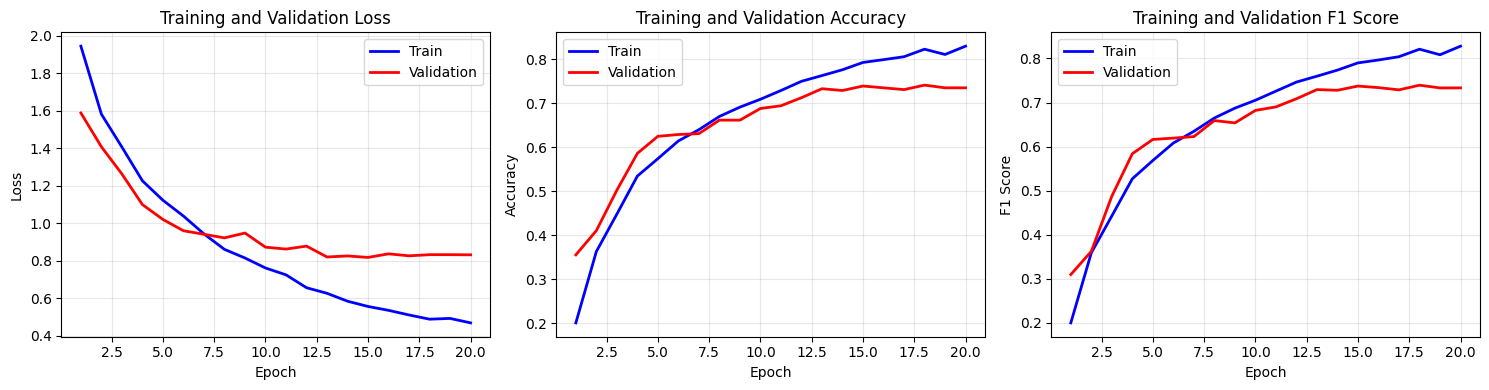

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs_range, history['train_f1'], 'b-', label='Train', linewidth=2)
axes[2].plot(epochs_range, history['val_f1'], 'r-', label='Validation', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Training and Validation F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## Evaluation

In [29]:
checkpoint_path = Path('best_model.pt')
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")

test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score (weighted): {test_f1:.4f}")

Loaded best model from epoch 18


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]


Test Results:
Loss: 0.8967
Accuracy: 0.6898
F1 Score (weighted): 0.6850


In [30]:
print("\nClassification Report:")
target_names = [complexity_labels[i] for i in range(NUM_CLASSES)]
print(classification_report(test_labels, test_preds, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

    constant       0.84      0.72      0.78        79
       cubic       0.64      0.77      0.70        61
      linear       0.59      0.45      0.51        85
        logn       0.75      0.84      0.79        67
       nlogn       0.64      0.69      0.66        80
          np       0.75      0.87      0.81        53
   quadratic       0.63      0.60      0.61        65

    accuracy                           0.69       490
   macro avg       0.69      0.70      0.69       490
weighted avg       0.69      0.69      0.68       490



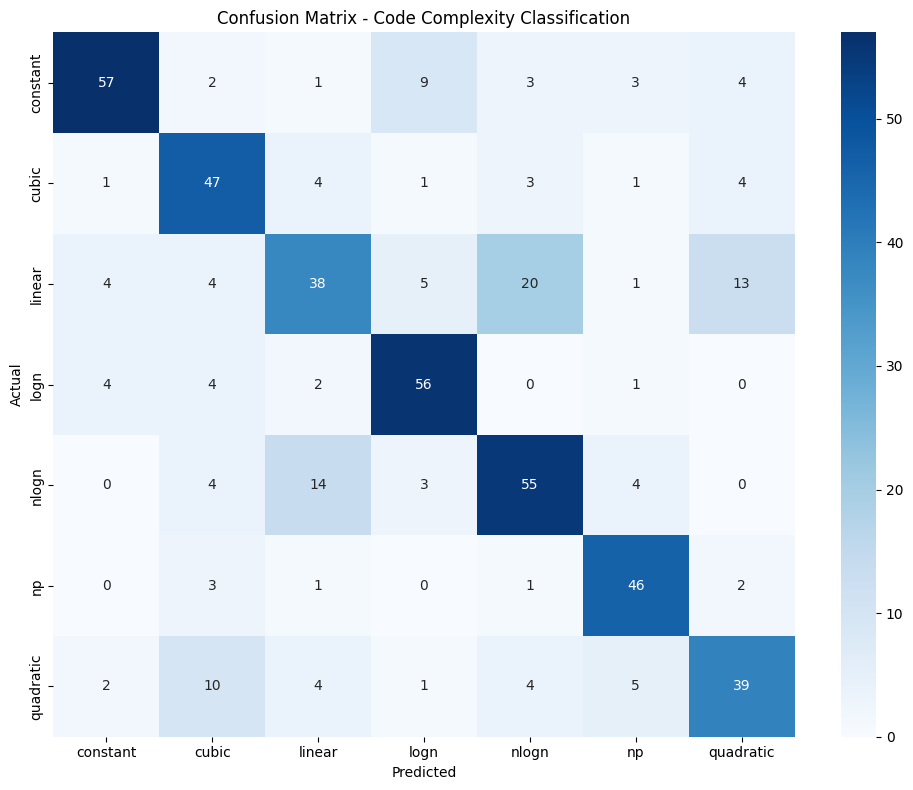

In [31]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Code Complexity Classification')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Inference Function

In [34]:
# Quick inference on held-out test set samples
model.eval()


def infer_on_test(dataset, count: int = 10) -> pd.DataFrame:
    rows = []
    limit = min(count, len(dataset))
    with torch.no_grad():
        for i in range(limit):
            sample = dataset[i]
            input_ids = sample['input_ids'].unsqueeze(0).to(device)
            attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
            true_label = sample['labels'].item()

            logits = model(input_ids, attention_mask)
            probs = F.softmax(logits, dim=1)[0].cpu().numpy()
            pred_idx = int(probs.argmax())
            rows.append({
                'sample_idx': i,
                'true_label': id2label[true_label],
                'pred_label': id2label[pred_idx],
                'confidence': float(probs[pred_idx])
            })
    return pd.DataFrame(rows)

sample_inference = infer_on_test(test_dataset, count=10)
sample_inference

,sample_idx,true_label,pred_label,confidence
0,0,linear,nlogn,0.910400
1,1,constant,quadratic,0.767651
2,2,np,np,0.990837
3,3,constant,constant,0.976205
4,4,np,np,0.997818
5,5,constant,constant,0.986975
6,6,cubic,cubic,0.998586
7,7,nlogn,linear,0.463407
8,8,cubic,cubic,0.609298
9,9,logn,constant,0.716961


## Saving model

In [35]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': MODEL_CONFIG,
    'complexity_labels': complexity_labels,
    'max_length': MAX_LENGTH,
    'label2id': label2id,
    'id2label': id2label
}, 'final_model.pt')

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!
